In [1]:
!nvidia-smi

Sat Aug 28 06:42:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0   122W / 400W |   4140MiB / 40536MiB |     74%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install torchsummary
# !pip install lpips

In [3]:
import sys

if ".." not in sys.path:
    sys.path.append("..")

In [4]:
import torch
from torchsummary import summary
from hydra.utils import instantiate

import argparse
from datetime import datetime
import os
import yaml
from omegaconf import OmegaConf
from tqdm import tqdm

# from modules.dataset import CityscapesDataset
from modules.loss import Pix2PixHDLoss
from utils import parse_config, get_lr_lambda, weights_init, freeze_encoder, show_tensor_images

In [5]:
def parse_arguments():
    parser = argparse.ArgumentParser()
#     parser.add_argument('-c', '--config', type=str, required=True)
    parser.add_argument('-c', '--config', type=str)
    parser.add_argument('-r', '--high_res', action='store_true', default=False)
    return parser.parse_args('')

## Create dataloader for generated faces and interpolated result.

In [6]:
import os
from collections.abc import Iterable
import glob

import torch
import numpy as np
import torchvision.transforms as transforms
from PIL import Image


In [7]:
def scale_width(img, target_width, method):
    ''' Scales an image to target_width while retaining aspect ratio '''
    w, h = img.size
    if w == target_width: return img
    target_height = target_width * h // w
    return img.resize((target_width, target_height), method)

In [8]:
class StyleGANFaces(torch.utils.data.Dataset):
    ''' Implements dataset with preprocessing for Cityscapes dataset '''

    def __init__(self,
                 path_A,
                 path_B,
                 path_AtoB,
                 path_BtoA,
                 ext=".png",
                 target_width=256):
        super().__init__()
        
        self.path_A = path_A
        self.path_B = path_B
        self.path_AtoB = path_AtoB
        self.path_BtoA = path_BtoA

        self.files_A = sorted(glob.glob(f'{path_A}/*{ext}'))
        self.files_B = sorted(glob.glob(f'{path_B}/*{ext}'))
        self.files_AtoB = sorted(glob.glob(f'{path_AtoB}/*{ext}'))
        self.files_BtoA = sorted(glob.glob(f'{path_BtoA}/*{ext}'))
        assert len(self.files_A) == len(self.files_B) == len(self.files_AtoB) == len(self.files_BtoA)

        # Initialize transforms for the real color image
        self.img_transforms = transforms.Compose([
            transforms.Lambda(lambda img: scale_width(img, target_width, Image.BICUBIC)),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        
    def __getitem__(self, idx: int):
        img_A = self.img_transforms(Image.open(self.files_A[idx]))
        img_B = self.img_transforms(Image.open(self.files_B[idx]))
        img_AtoB = self.img_transforms(Image.open(self.files_AtoB[idx]))
        img_BtoA = self.img_transforms(Image.open(self.files_BtoA[idx]))
        
        return (img_A, img_B, img_AtoB, img_BtoA)

    
    def __len__(self):
        ''' All have been asserted to be equal length, so just return one'''
        return len(self.files_A)


#     @staticmethod
#     def collate_fn(batch):
#         imgs, labels, insts, bounds = [], [], [], []
#         for (x, l, i, b) in batch:
#             imgs.append(x)
#             labels.append(l)
#             insts.append(i)
#             bounds.append(b)
#         return (
#             torch.stack(imgs, dim=0),
#             torch.stack(labels, dim=0),
#             torch.stack(insts, dim=0),
#             torch.stack(bounds, dim=0),
#         )

In [39]:
dataset = StyleGANFaces(
    path_A="../../dataset/image-to-image/trainA",
    path_B="../../dataset/image-to-image/trainB",
    path_AtoB = "../../dataset/image-to-image/images_AtoB",
    path_BtoA = "../../dataset/image-to-image/images_BtoA"
)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, sampler=None,
    num_workers=0, collate_fn=None,
    pin_memory=True, drop_last=True,
)

In [42]:
for batch in dataloader:
    img_A, img_B, img_AtoB, img_BtoA = batch
    print(img_A.shape, img_B.shape)
    break

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


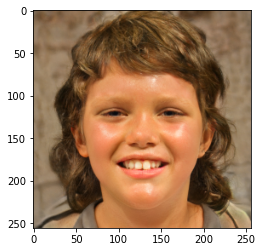

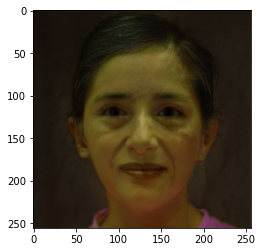

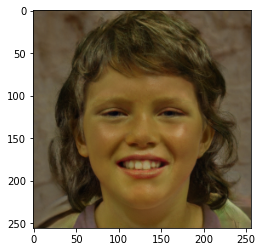

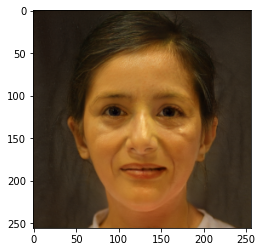

In [43]:
show_tensor_images(img_A)
show_tensor_images(img_B)
show_tensor_images(img_AtoB)
show_tensor_images(img_BtoA)



In [12]:
############# main() ###############
#

args = parse_arguments()
args.config = "notebook_lowres_custom.yml"

with open(args.config, 'r') as f:
    config = yaml.safe_load(f)
    config = OmegaConf.create(config)
    config = parse_config(config)
    
print(config)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = instantiate(config.encoder).to(device).apply(weights_init)
generator = instantiate(config.generator).to(device).apply(weights_init)
discriminator = instantiate(config.discriminator).to(device).apply(weights_init)

# summary(encoder, (3, 256, 256))
# summary(generator, (6, 256, 256))
# summary(discriminator, (3, 256, 256))

{'target_width': 1024, 'n_classes': 35, 'n_features': 3, 'rgb': 3, 'train_dataset': {'_target_': 'modules.dataset.CityscapesDataset', 'paths': ['data/gtFine_trainvaltest/gtFine/train', 'data/leftImg8bit_trainvaltest/leftImg8bit/train'], 'target_width': 1024, 'n_classes': 35}, 'train_dataloader': {'batch_size': 1, 'shuffle': True, 'pin_memory': True}, 'val_dataset': {'_target_': 'modules.dataset.CityscapesDataset', 'paths': ['data/gtFine_trainvaltest/gtFine/val', 'data/leftImg8bit_trainvaltest/leftImg8bit/val'], 'target_width': 1024, 'n_classes': 35}, 'val_dataloader': {'batch_size': 8, 'drop_last': False, 'shuffle': False, 'pin_memory': True}, 'generator': {'_target_': 'modules.networks.GlobalGenerator', 'in_channels': 9, 'out_channels': 3, 'base_channels': 64, 'fb_blocks': 3, 'res_blocks': 9}, 'discriminator': {'_target_': 'modules.networks.MultiscaleDiscriminator', 'in_channels': 9, 'base_channels': 64, 'n_layers': 3, 'n_discriminators': 2}, 'encoder': {'_target_': 'modules.networks.

In [13]:
# b_enc = encoder(img_B.cuda())
# print(b_enc.shape)
# print(img_A.shape)

# x = torch.cat([img_A.cuda(), b_enc], dim=1)
# print(x.shape)

# x = generator(x)
# print(x.shape)

# y = discriminator(x)
# print()
# for dis in y:
#     for b in dis:
#         print(b.shape)

# # show_tensor_images(b_enc)
# # show_tensor_images(x)


In [14]:
if args.high_res:
    g_optimizer = torch.optim.Adam(
        list(generator.parameters()), **config.optim,
    )
else:
    g_optimizer = torch.optim.Adam(
        list(generator.parameters()) + list(encoder.parameters()), **config.optim,
    )
d_optimizer = torch.optim.Adam(list(discriminator.parameters()), **config.optim)
g_scheduler = torch.optim.lr_scheduler.LambdaLR(
    g_optimizer,
    get_lr_lambda(config.train.epochs, config.train.decay_after),
)
d_scheduler = torch.optim.lr_scheduler.LambdaLR(
    d_optimizer,
    get_lr_lambda(config.train.epochs, config.train.decay_after),
)



In [15]:
start_epoch = 0
if config.resume_checkpoint is not None:
    state_dict = torch.load(config.resume_checkpoint)

    encoder.load_state_dict(state_dict['e_model_dict'])
    generator.load_state_dict(state_dict['g_model_dict'])
    discriminator.load_state_dict(state_dict['d_model_dict'])
    g_optimizer.load_state_dict(state_dict['g_optim_dict'])
    d_optimizer.load_state_dict(state_dict['d_optim_dict'])
    start_epoch = state_dict['epoch']

    msg = 'high-res' if args.high_res else 'low-res'
    print(f'Starting {msg} training from checkpoints')

elif args.high_res:
    state_dict = config.pretrain_checkpoint
    if state_dict is not None:
        encoder.load_state_dict(torch.load(state_dict['e_model_dict']))
        encoder = freeze_encoder(encoder)
        generator.g1.load_state_dict(torch.load(state_dict['g_model_dict']))
        print('Starting high-res training from pretrained low-res checkpoints')
    else:
        print('Starting high-res training from scratch (no valid checkpoint detected)')

else:
    print('Starting low-res training from random initialization')

Starting low-res training from random initialization


In [16]:
import lpips

lpips_loss = lpips.LPIPS(net='alex').cuda()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from modules.networks import VGG19

device='cuda'
lambda1=10. 
lambda2=10.
norm_weight_to_one=True

vgg = VGG19().to(device)
vgg_weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0]

lambda0 = 1.0
# Keep ratio of composite loss, but scale down max to 1.0
scale = max(lambda0, lambda1, lambda2) if norm_weight_to_one else 1.0

lambda0 = lambda0 / scale
lambda1 = lambda1 / scale
lambda2 = lambda2 / scale


In [33]:
def vgg_loss(x_real, x_fake):
    ''' Computes perceptual loss with VGG network from real and fake images '''
    vgg_real = vgg(x_real)
    vgg_fake = vgg(x_fake)

    vgg_loss = 0.0
    for real, fake, weight in zip(vgg_real, vgg_fake, vgg_weights):
        vgg_loss += weight * F.l1_loss(real.detach(), fake)

    return vgg_loss


def fm_loss(real_preds, fake_preds):
    ''' Computes feature matching loss from nested lists of fake and real outputs from discriminator '''
    fm_loss = 0.0
    for real_features, fake_features in zip(real_preds, fake_preds):
        for real_feature, fake_feature in zip(real_features, fake_features):
            fm_loss += F.l1_loss(real_feature.detach(), fake_feature)
    
    return fm_loss


def adv_loss(discriminator_preds, is_real):
    ''' Computes adversarial loss from nested list of fakes outputs from discriminator '''
    target = torch.ones_like if is_real else torch.zeros_like

    adv_loss = 0.0
    for preds in discriminator_preds:
        pred = preds[-1]
        adv_loss += F.mse_loss(pred, target(pred))
    
    return adv_loss


def enc_loss(f_map, img_orig):
    return F.l1_loss(f_map, img_orig)


def forward_loss(img_A, img_B, img_AtoB, encoder, generator, discriminator):
    # Forward call of loss.
    #
    x_real = img_AtoB

#     feature_map = encoder(img_B)
    feature_map = encoder(torch.cat((img_A, img_B), dim=1))
    x_fake = generator(torch.cat((img_A, img_B, feature_map), dim=1))
#     print(feature_map.shape)
#     print(x_fake.shape)

    # Get necessary outputs for loss/backprop for both generator and discriminator
#     fake_preds_for_g = discriminator(x_fake)
#     fake_preds_for_d = discriminator(x_fake.detach())
#     real_preds_for_d = discriminator(x_real.detach())
    fake_preds_for_g = discriminator(torch.cat((img_A, img_B, x_fake), dim=1))
    fake_preds_for_d = discriminator(torch.cat((img_A, img_B, x_fake.detach()), dim=1))
    real_preds_for_d = discriminator(torch.cat((img_A, img_B, x_real.detach()), dim=1))

    g_loss = (
        lambda0 * adv_loss(fake_preds_for_g, False) + \
        lambda1 * fm_loss(real_preds_for_d, fake_preds_for_g) / discriminator.n_discriminators + \
        lambda2 * vgg_loss(x_fake, x_real)  + \
#         1.0 * enc_loss(feature_map, img_B) + \
        2.0 * lpips_loss(x_fake, img_AtoB)
    )

    d_loss = 0.5 * (
        adv_loss(real_preds_for_d, True) + \
        adv_loss(fake_preds_for_d, False)
    )

    return g_loss, d_loss, x_fake.detach()


In [35]:
for epoch in tqdm(range(0, 2)):
    # training epoch
    #
    mean_g_loss = 0.0
    mean_d_loss = 0.0
    epoch_steps = 0
    if not args.high_res:
        encoder.train()
    
    generator.train()
    discriminator.train()
    
    pbar = tqdm(dataloader, position=0, desc='train [G loss: -.----][D loss: -.----]')
    for batch in pbar:
        img_A, img_B, img_AtoB, img_BtoA = batch
        img_A = img_A.to(device)
        img_B = img_B.to(device)
        img_AtoB = img_AtoB.to(device)
        img_BtoA = img_BtoA.to(device)
        
        g_loss, d_loss, x_fake = forward_loss(
            img_A,
            img_B,
            img_AtoB,
            encoder,
            generator,
            discriminator
        )
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        mean_g_loss += g_loss.item()
        mean_d_loss += d_loss.item()
        epoch_steps += 1

        pbar.set_description(desc=f'train [G loss: {mean_g_loss/epoch_steps:.4f}][D loss: {mean_d_loss/epoch_steps:.4f}]')

    g_scheduler.step()
    d_scheduler.step()
    

100%|██████████| 2/2 [07:12<00:00, 216.49s/it]


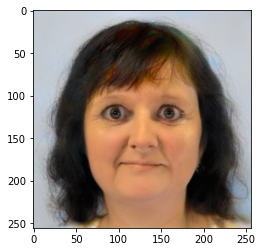

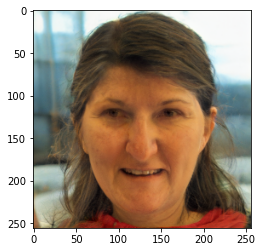

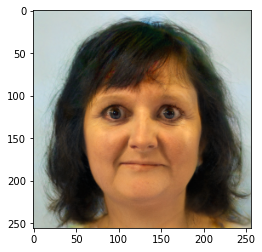

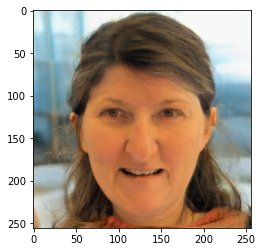

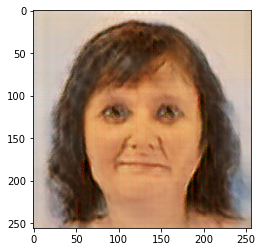

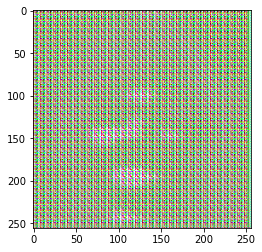

In [36]:
if not args.high_res:
    encoder.eval()
generator.eval()
discriminator.eval()

for i, batch in enumerate(dataloader):
    img_A, img_B, img_AtoB, img_BtoA = batch
    img_A = img_A.to(device)
    img_B = img_B.to(device)
    img_AtoB = img_AtoB.to(device)
    img_BtoA = img_BtoA.to(device)
    
    if i==2: break
    
with torch.no_grad():
#     feature_map = encoder(img_B)
#     x_fake = generator(torch.cat((img_A, feature_map), dim=1))
    feature_map = encoder(torch.cat((img_A, img_B), dim=1))
    x_fake = generator(torch.cat((img_A, img_B, feature_map), dim=1))
    

show_tensor_images(img_A)
show_tensor_images(img_B)
show_tensor_images(img_AtoB)
show_tensor_images(img_BtoA)
show_tensor_images(x_fake)
show_tensor_images(feature_map)


In [38]:
2.0 * lpips_loss(x_fake, img_AtoB)

tensor([[[[0.4200]]]], device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
# initialize logging
loss = Pix2PixHDLoss(device=device)
# log_dir = os.path.join(train_config.log_dir, datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
# os.makedirs(log_dir, mode=0o775, exist_ok=False)

for epoch in range(start_epoch, config.epochs):
    # training epoch
    mean_g_loss = 0.0
    mean_d_loss = 0.0
    epoch_steps = 0
    if not high_res:
        encoder.train()
    generator.train()
    discriminator.train()
    pbar = tqdm(train_dataloader, position=0, desc='train [G loss: -.----][D loss: -.----]')
    for (x_real, labels, insts, bounds) in pbar:
        x_real = x_real.to(device)
        labels = labels.to(device)
        insts = insts.to(device)
        bounds = bounds.to(device)

        with torch.cuda.amp.autocast(enabled=(device=='cuda')):
            g_loss, d_loss, x_fake = loss(
                x_real, labels, insts, bounds, encoder, generator, discriminator,
            )

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        mean_g_loss += g_loss.item()
        mean_d_loss += d_loss.item()
        epoch_steps += 1

        pbar.set_description(desc=f'train [G loss: {mean_g_loss/epoch_steps:.4f}][D loss: {mean_d_loss/epoch_steps:.4f}]')

    if epoch+1 % train_config.save_every == 0:
        torch.save({
            'e_model_dict': encoder.state_dict(),
            'g_model_dict': generator.state_dict(),
            'd_model_dict': discriminator.state_dict(),
            'g_optim_dict': g_optimizer.state_dict(),
            'd_optim_dict': d_optimizer.state_dict(),
            'epoch': epoch,
        }, os.path.join(log_dir, f'epoch={epoch}.pt'))

    g_scheduler.step()
    d_scheduler.step()

